- 「お弁当の需要予測」という小規模なデータセットのコンペを題材に、売上の要因を簡単に分析しながらモデルを組み立てるところまで実施した
- 線形と非線形のモデル2つを作成し、これを組み合わせて予測を行う手法を今回は試みた
- Trainデータでのクロスバリデーションの結果、RMSEは11前後程度となった

# Introduction

- 「お弁当の需要予測」は実際にお昼に販売されたお弁当の売上数を予測する問題で、回帰問題として分類される
- まずはデータを読み込み、売上数と説明変数との関係を基礎分析で確認する

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
# スタイルの適用
sns.set(font="IPAexGothic",style="white")

In [2]:
train  = pd.read_csv("../00_Data/train.csv")
test   = pd.read_csv("../00_Data/test.csv")
sample = pd.read_csv("../00_Data/sample.csv", header=None)
print("Data Shape")
print("Train:", train.shape, "Test:", test.shape, "Sample:", sample.shape)

Data Shape
Train: (207, 12) Test: (40, 11) Sample: (40, 2)


In [3]:
train.index = pd.to_datetime(train["datetime"])
train.head()

,datetime,y,week,soldout,name,kcal,remarks,event,payday,weather,precipitation,temperature
datetime,,,,,,,,,,,,
2013-11-18,2013-11-18,90,月,0,厚切りイカフライ,NaN,NaN,NaN,NaN,快晴,--,19.8
2013-11-19,2013-11-19,101,火,1,手作りヒレカツ,NaN,NaN,NaN,NaN,快晴,--,17.0
2013-11-20,2013-11-20,118,水,0,白身魚唐揚げ野菜あん,NaN,NaN,NaN,NaN,快晴,--,15.5
2013-11-21,2013-11-21,120,木,1,若鶏ピリ辛焼,NaN,NaN,NaN,NaN,快晴,--,15.2
2013-11-22,2013-11-22,130,金,1,ビッグメンチカツ,NaN,NaN,NaN,NaN,快晴,--,16.1


In [4]:
train.describe()

,y,soldout,kcal,payday,temperature
count,207.000000,207.000000,166.000000,10.0,207.000000
mean,86.623188,0.449275,404.409639,1.0,19.252174
std,32.882448,0.498626,29.884641,0.0,8.611365
min,29.000000,0.000000,315.000000,1.0,1.200000
25%,57.000000,0.000000,386.000000,1.0,11.550000
50%,78.000000,0.000000,408.500000,1.0,19.800000
75%,113.000000,1.000000,426.000000,1.0,26.100000
max,171.000000,1.000000,462.000000,1.0,34.600000


In [5]:
# オブジェクト要素の基本統計量
train.describe(include="O")

,datetime,week,name,remarks,event,weather,precipitation
count,207,207,207,21,14,207,207
unique,207,5,156,6,2,7,8
top,2014-6-16,水,メンチカツ,お楽しみメニュー,ママの会,快晴,--
freq,1,43,6,12,9,53,169


- 簡単な欠損値補間と月情報の特徴量の作成

In [6]:
# 欠損値を0(非給料日)で補間
train["payday"] = train["payday"].fillna(0)
# 欠損値"--" だったら-1にする関数を適用しapplyで上書き
train["precipitation"] = train["precipitation"].apply(
                             lambda x : -1 if x == "--" else float(x)
                         )
train["event"]   = train["event"].fillna("なし")
train["remarks"] = train["remarks"].fillna("なし")

# 月情報の新規作成
# 日付からsplitで月のみを抽出
train["month"] = train["datetime"].apply(
                     lambda x : int(x.split("-")[1])
                 )

- お弁当の売上分布の確認

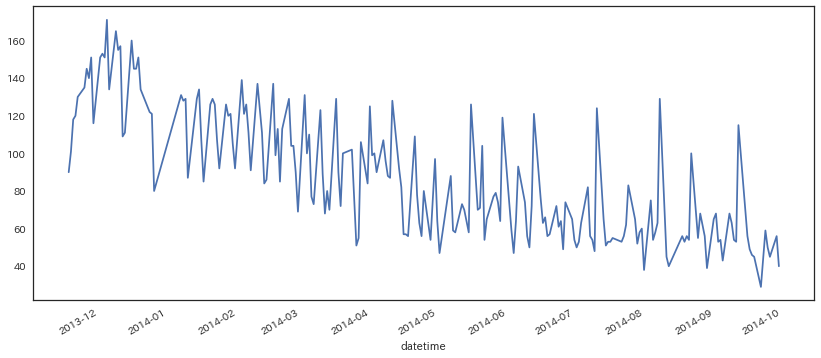

In [7]:
# figsizeで図のサイズ設定(単位はインチ、デフォは(8,6))
train["y"].plot(figsize=(14,6))

↓
- 日数が経過するにつれて売上が落ちていっている
- 落ちていっているにも関わらず、スパイク（急上昇）しているため、売上数に寄与している何らかのファクターがある？

- 目的変数と説明変数（数値変数）と散布図の確認

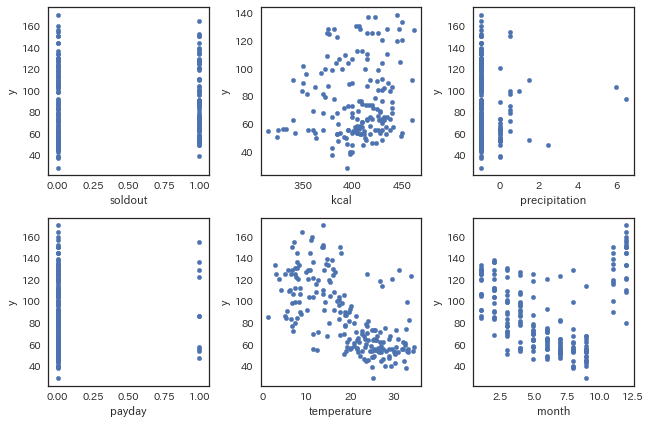

In [8]:
# 2行,3列でグラフ表示
# fig = 座標全体
# ax  = 内部の座標軸
fig, ax = plt.subplots(2, 3, figsize=(9,6))

train.plot.scatter(x="soldout",       y="y", ax=ax[0][0])
train.plot.scatter(x="kcal",          y="y", ax=ax[0][1])
train.plot.scatter(x="precipitation", y="y", ax=ax[0][2])
train.plot.scatter(x="payday",        y="y", ax=ax[1][0])
train.plot.scatter(x="temperature",   y="y", ax=ax[1][1])
train.plot.scatter(x="month",         y="y", ax=ax[1][2])
# グラフのラベル同士が重ならないようにして表示
plt.tight_layout()

↓
- 月及び気温は売上数と相関が高そうだが、日数が経過するにつれて減衰している性質があるため、代替変数である可能性が高い

- 目的変数と説明変数（カテゴリー変数）との箱ひげ図の確認

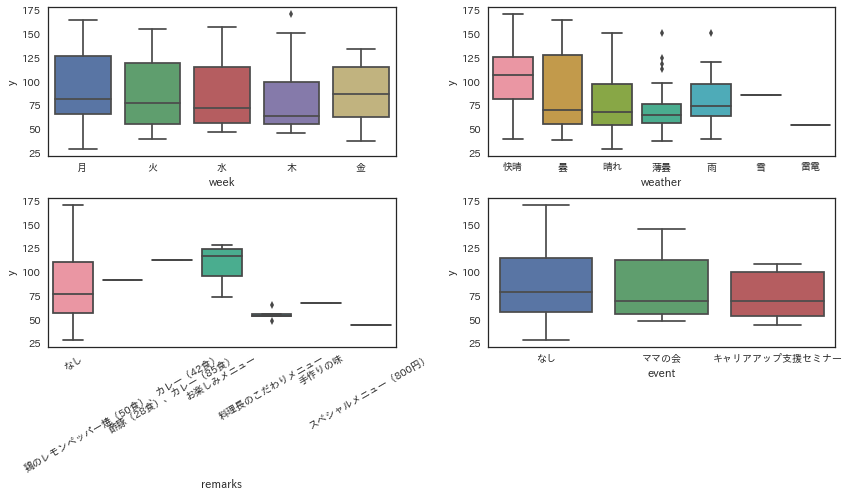

In [9]:
fig, ax = plt.subplots(2, 2, figsize=(12, 7))

sns.boxplot(x="week",    y="y", data=train, ax=ax[0][0])
sns.boxplot(x="weather", y="y", data=train, ax=ax[0][1])
sns.boxplot(x="remarks", y="y", data=train, ax=ax[1][0])
# ラベルの角度を30度回転
ax[1][0].set_xticklabels(ax[1][0].get_xticklabels(), rotation=30)
sns.boxplot(x="event",   y="y", data=train, ax=ax[1][1])

plt.tight_layout()

↓
- 顕著に売上数に反応しているのはremarks<br>
お楽しみメニューのときになしの場合と変化あり

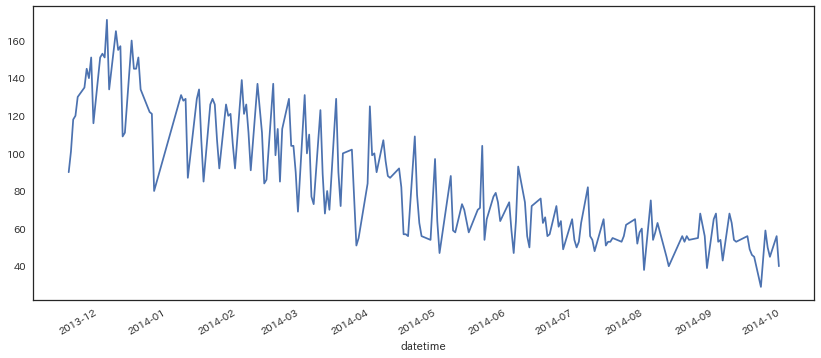

In [13]:
train[train["remarks"] != "お楽しみメニュー"]["y"].plot(figsize=(14,6))

↓
- お楽しみメニューを除いた場合に、後半の売上数のスパイクが減少=スパイクの原因はお楽しみメニューであるかもしれない

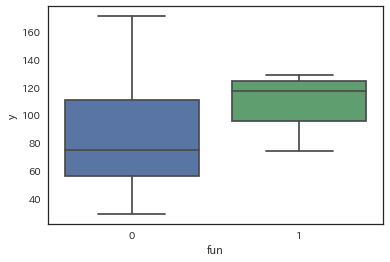

In [14]:
train["fun"] = train["remarks"].apply(
                   lambda x : 1 if x == "お楽しみメニュー" else 0
               )
sns.boxplot(x="fun", y="y", data=train)

- メディアン検定

In [17]:
from scipy.stats import median_test
stat, p, med, tbl = median_test(
                        train[train["fun"] == 1]["y"],
                        train[train["fun"] == 0]["y"]
                    )
print("p", p, "stat", stat)

p 0.007057960766247775 stat 7.2581589841730345


↓
- お楽しみメニューであるかないかで比較しても、中央値検定では有意に差がある(p < 0.05)

- お楽しみメニューのときの売上を確認

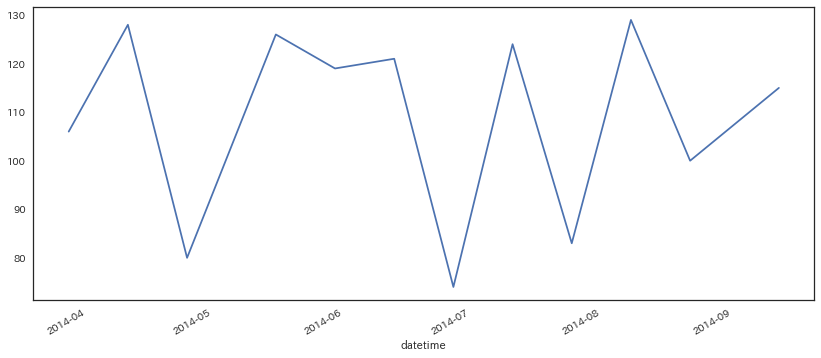

In [19]:
train[train["remarks"] == "お楽しみメニュー"]["y"].plot(figsize=(14,6))

↓
- お楽しみメニューの中でも凹凸が見られる

- お楽しみメニューの内容を確認

In [20]:
train[train["remarks"] == "お楽しみメニュー"]

,datetime,y,week,soldout,name,kcal,remarks,event,payday,weather,precipitation,temperature,month,fun
datetime,,,,,,,,,,,,,,
2014-03-28,2014-3-28,106,金,0,キーマカレー,NaN,お楽しみメニュー,なし,0.0,快晴,-1.0,18.5,3,1
2014-04-11,2014-4-11,128,金,1,チキンカレー,NaN,お楽しみメニュー,なし,0.0,快晴,-1.0,16.5,4,1
2014-04-25,2014-4-25,80,金,0,中華丼,NaN,お楽しみメニュー,なし,0.0,晴れ,-1.0,20.8,4,1
2014-05-16,2014-5-16,126,金,0,ポークカレー,NaN,お楽しみメニュー,ママの会,0.0,快晴,-1.0,23.8,5,1
2014-05-30,2014-5-30,119,金,0,チキンカレー,NaN,お楽しみメニュー,なし,0.0,薄曇,-1.0,26.9,5,1
2014-06-13,2014-6-13,121,金,0,キーマカレー,NaN,お楽しみメニュー,なし,0.0,晴れ,-1.0,29.5,6,1
2014-06-27,2014-6-27,74,金,0,牛丼,NaN,お楽しみメニュー,なし,0.0,雨,0.0,25.4,6,1
2014-07-11,2014-7-11,124,金,0,ポークカレー,NaN,お楽しみメニュー,なし,0.0,晴れ,-1.0,33.9,7,1
2014-07-25,2014-7-25,83,金,0,ひやしたぬきうどん・炊き込みご飯,NaN,お楽しみメニュー,なし,0.0,晴れ,-1.0,33.6,7,1


↓
- カレーか否かが重要？

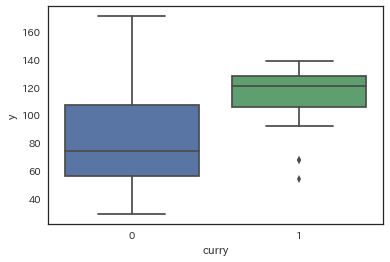

In [21]:
# x.findで名前にカレーを含むかの特徴量を生成
train["curry"] = train["name"].apply(
                     lambda x : 1 if x.find("カレー") >= 0 else 0
                 )
sns.boxplot(x="curry", y="y", data=train)

- メディアン検定

In [22]:
stat, p, med, tbl = median_test(
                        train[train["curry"] == 1]["y"],
                        train[train["curry"] == 0]["y"]
                    )
print("p", p, "stat", stat)

p 0.010699742900892427 stat 6.514516162828877


↓
- どうやらカレーか否かが重要そうである(p<0.05)

# Method

- 方針としては日数が経過するにつれて減衰しているため、売上数と日数の単回帰モデルを軸に検討する
    - ただし、2014-05以前はやや傾向が異なるため、学習データから除く
- お楽しみメニューやカレーなどは大きく寄与はしていそうだが、非線形な関係であることも考慮し、Random Forestを用いて単回帰モデルの結果を修正するモデルも作成し、予測結果を導出することにする

In [27]:
train  = pd.read_csv("../00_Data/train.csv")
test   = pd.read_csv("../00_Data/test.csv")
sample = pd.read_csv("../00_Data/sample.csv", header=None)

In [34]:
train["t"] = 1
test["t"]  = 0
# チュートリアルでは
# pd.concat([train,test], sort=True).reset_index(drop=True)
# となっているが、
# TypeError: concat() got an unexpected keyword argument 'sort'
# となるため外した
# drop=Trueとすることでreset前のindexがデータ列に移動しなくなる
dat = pd.concat([train,test]).reset_index(drop=True)

In [35]:
dat.head()

,datetime,event,kcal,name,payday,precipitation,remarks,soldout,t,temperature,weather,week,y
0,2013-11-18,NaN,NaN,厚切りイカフライ,NaN,--,NaN,0,1,19.8,快晴,月,90.0
1,2013-11-19,NaN,NaN,手作りヒレカツ,NaN,--,NaN,1,1,17.0,快晴,火,101.0
2,2013-11-20,NaN,NaN,白身魚唐揚げ野菜あん,NaN,--,NaN,0,1,15.5,快晴,水,118.0
3,2013-11-21,NaN,NaN,若鶏ピリ辛焼,NaN,--,NaN,1,1,15.2,快晴,木,120.0
4,2013-11-22,NaN,NaN,ビッグメンチカツ,NaN,--,NaN,1,1,16.1,快晴,金,130.0


In [43]:
# indexを日付に変更後、インデックスの範囲指定で20140501以降のデータにし、
# indexを再度数値にリセットする
dat.index = pd.to_datetime(dat["datetime"])
dat = dat["2014-05-01":]
dat = dat.reset_index(drop=True)

In [44]:
dat.head()

,datetime,event,kcal,name,payday,precipitation,remarks,soldout,t,temperature,weather,week,y
0,2014-5-1,NaN,415.0,マーボ茄子,NaN,--,NaN,0,1,24.0,晴れ,木,64.0
1,2014-5-2,NaN,420.0,鶏の天ぷら,NaN,--,NaN,0,1,23.3,晴れ,金,47.0
2,2014-5-7,NaN,415.0,肉じゃが,NaN,--,NaN,1,1,18.9,晴れ,水,88.0
3,2014-5-8,NaN,405.0,メンチカツ,NaN,--,NaN,0,1,21.0,薄曇,木,59.0
4,2014-5-9,NaN,434.0,手作りチキンカツ,1.0,--,NaN,1,1,23.4,晴れ,金,58.0


In [47]:
# 経過日数の特徴量を新規作成
dat["days"] = dat.index

dat["precipitation"] = dat["precipitation"].apply(
                           lambda x : -1 if x == "--" else x
                       ).astype(np.float)
dat["fun"] = dat["remarks"].apply(
                           lambda x : 1 if x == "お楽しみメニュー" else 0
                       )
dat["curry"] = dat["name"].apply(
                           lambda x : 1 if x.find("カレー") >= 0 else 0
                       )

cols = ["precipitation", "weather", "days", "fun", "curry", "y"]

In [48]:
from sklearn.model_selection import KFold
# 平均二乗誤差
from sklearn.metrics import mean_squared_error as MSE
# 線形回帰
from sklearn.linear_model import LinearRegression as LR
from sklearn.ensemble import RandomForestRegressor as RF

In [81]:
# 学習モデルを返す
def learning(x_train, y_train):
    # 線形回帰
    model1 = LR()
    # ランダムフォレスト
    model2 = RF(n_estimators=100, max_depth=4, random_state=777)
    
    # reshape(-1, 1)は-1で行ベクトルにしたあと、列数1にする
    # 経過日数で単回帰
    model1.fit(x_train["days"].values.reshape(-1, 1), y_train)
    pred = model1.predict(x_train["days"].values.reshape(-1, 1))
    
    # 単回帰の予測値と実測値の差を代入
    pred_sub = y_train - pred
    # 列名がyか否かの結果を~で反転している
    # falseの場合はilocの抽出対象から除外される
    # 単回帰でのズレを目的変数にしてRFを実施
    model2.fit(x_train.iloc[:, ~x_train.columns.str.match("y")], pred_sub)
    
    return model1, model2

# Evaluation

- sklearnではRMSEが実装されていないため、MSEに対してルートを取ることで導出する（累乗は**演算子を利用する）
- ダミー変数化について
    - 天気情報の値がtrainにはあるがtestにはないものが存在するため、別々でダミー変数化をするとカラムの数が合わなくなる
    - そのため、trainとtestを識別するための適当な変数を作成してから一度結合し、ダミー変数化した後に戻すという手順を実施する

In [61]:
# 5分割
kf = KFold(n_splits=5, random_state=777)
# trainデータのcols列を抽出
tr = dat[dat["t"] == 1][cols]

In [62]:
tr

,precipitation,weather,days,fun,curry,y
0,-1.0,晴れ,0,0,0,64.0
1,-1.0,晴れ,1,0,0,47.0
2,-1.0,晴れ,2,0,0,88.0
3,-1.0,薄曇,3,0,0,59.0
4,-1.0,晴れ,4,0,0,58.0
5,-1.0,薄曇,5,0,0,73.0
6,0.0,雨,6,0,0,70.0
7,-1.0,薄曇,7,0,0,64.0
8,-1.0,曇,8,0,0,58.0
9,-1.0,快晴,9,1,1,126.0


In [87]:
# MSEの格納用(平均算出時に使用)
trains = []
tests  = []

for train_index, test_index in kf.split(tr):
    # ttはKFoldの中でtrainとtestを区別するための列
    tr.loc[train_index, "tt"] = 1
    tr.loc[test_index,  "tt"] = 0
    tr["tt"] = tr["tt"].astype(np.int)
    tmp_dummy = pd.get_dummies(tr)
    
    # ダミー変数化したため、不要列を削除
    x_train = tmp_dummy[tmp_dummy["tt"] == 1]
    del x_train["tt"]
    x_test  = tmp_dummy[tmp_dummy["tt"] == 0]
    del x_test["tt"]
    
    y_train = tmp_dummy[tmp_dummy["tt"] == 1]["y"]
    y_test  = tmp_dummy[tmp_dummy["tt"] == 0]["y"]
    
    # モデル構築
    model1, model2 = learning(x_train, y_train)
    
    # RFは単回帰のズレを推測するため、
    # 単回帰+単回帰のズレ（RF）
    # とすることで2つのモデルを組み合わせた結果となる
    pred_train = model1.predict(x_train["days"].values.reshape(-1, 1))\
                 + \
                 model2.predict(
                     x_train.iloc[:, ~x_train.columns.str.match("y")]
                 )
    pred_test  = model1.predict(x_test["days"].values.reshape(-1, 1))\
                 + \
                 model2.predict(
                     x_test.iloc[:, ~x_test.columns.str.match("y")]
                 )
    
    print("TRAIN:",    MSE(y_train, pred_train)**0.5,
          "VARIDATE:", MSE(y_test,  pred_test) **0.5)
    
    trains.append(MSE(y_train, pred_train)**0.5)
    tests.append( MSE(y_test,  pred_test) **0.5)
    
print("AVG")
print(np.array(trains).mean(), np.array(tests).mean())

TRAIN: 7.567045890582926 VARIDATE: 12.108512732864117
TRAIN: 7.893719286467532 VARIDATE: 10.509438728462127
TRAIN: 8.266274249088164 VARIDATE: 8.843075664182068
TRAIN: 7.954599685874008 VARIDATE: 19.93205551309561
TRAIN: 7.913918883780418 VARIDATE: 9.443466823946043
AVG
7.91911159915861 12.16730989250999


↓
- cross validationでの検証からRMSEは大体11前後程度のモデルが作成できていることがわかる（大きく外れているのを除いた場合）

In [88]:
cols = ["precipitation", "weather", "days", "fun", "curry", "y", "t"]
tmp_dummy = pd.get_dummies(dat[cols])

x_train = tmp_dummy[tmp_dummy["t"] == 1]
del x_train["t"]
x_test  = tmp_dummy[tmp_dummy["t"] == 0]
del x_test["t"]
y_train = tmp_dummy[tmp_dummy["t"] == 1]["y"]
y_test  = tmp_dummy[tmp_dummy["t"] == 0]["y"]

- trainに対する予測と実績

RMSE 7.985164067635326


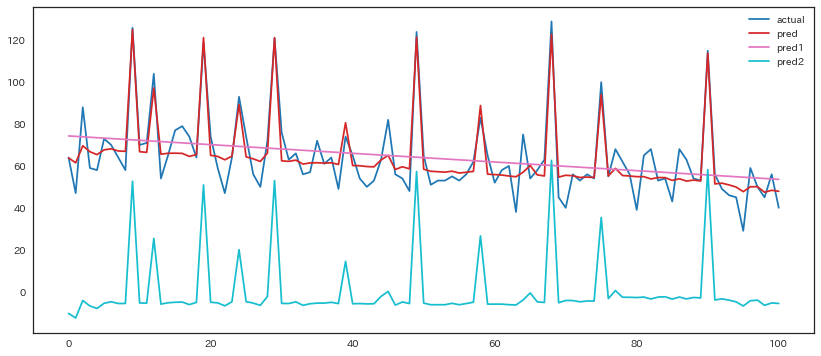

In [105]:
model1, model2 = learning(x_train, y_train)

pred = model1.predict(x_train["days"].values.reshape(-1, 1))\
       +\
       model2.predict(x_train.iloc[:, ~x_train.columns.str.match("y")])

pred1 = model1.predict(x_train["days"].values.reshape(-1, 1))
pred2 = model2.predict(x_train.iloc[:, ~x_train.columns.str.match("y")])
        
p = pd.DataFrame({
                    "actual":y_train, "pred":pred,
                    "pred1":pred1,    "pred2":pred2
                })
p.plot(figsize=(14,6), colormap="tab10")
print("RMSE", MSE(y_train, pred)**0.5)

↓
- 売上数が急増する部分についてはそれなりに予測ができているように見える
- 一方で、小さな凹凸についてはあまり予測ができておらず、説明変数の検討が更に必要

- testに対する予測

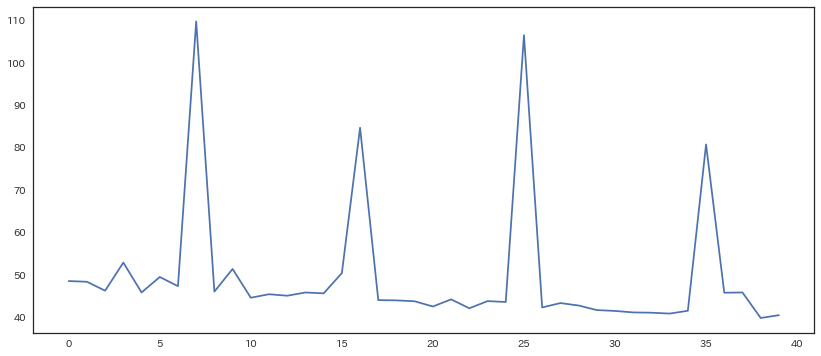

In [97]:
model1, model2 = learning(x_train, y_train)

pred = model1.predict(x_test["days"].values.reshape(-1, 1))\
       +\
       model2.predict(x_test.iloc[:, ~x_test.columns.str.match("y")])

plt.figure(figsize=(14,6))
plt.plot(pred)

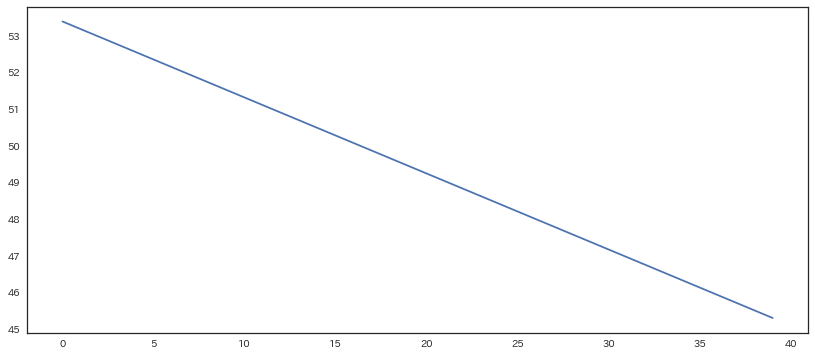

In [102]:
# 単回帰のみのグラフ
pred1 = model1.predict(x_test["days"].values.reshape(-1, 1))\
       
plt.figure(figsize=(14,6))
plt.plot(pred1)

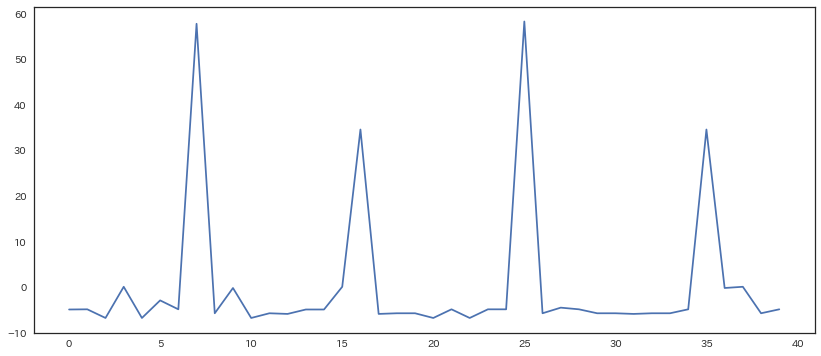

In [103]:
# RandomoForestのみのグラフ
pred2 = model2.predict(x_test.iloc[:, ~x_test.columns.str.match("y")])

plt.figure(figsize=(14,6))
plt.plot(pred2)

In [100]:
sample[1] = pred
sample.to_csv("../80_submit/submit01.csv", index=None, header=None)

# Conclution

- お弁当の需要予測を題材とし、基礎分析の結果から2種類のモデルを利用した
- 1つ目は日数が経過するごとに売上が減少傾向だったため、日数と需要量との単回帰モデルとした
- 2つ目は上記予想結果を更に細かく補正するための非線形なモデルとしてRandomForestを採用した
    - スパイク要因に注目したところ、お楽しみメニューやカレーかどうかが重要であると推測でき、これらを表す特徴量を加えた結果、スパイクが予測できていた
- 課題としては、小さな凹凸に対しては予測が不十分と考えられるため、これらに有効な特徴量を検討することである

# Reference
- [seabornのboxplotのコードの書き方のサンプル](http://seaborn.pydata.org/examples/horizontal_boxplot.html)
- [seabornでx軸のラベルを回転させたい](https://stackoverflow.com/questions/44954123/rotate-xtick-labels-in-seaborn-boxplot?utm_medium=organic&utm_source=google_rich_qa&utm_campaign=google_rich_qa)
- [sklearnのRandomForestの仕様について](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)
- [sklearnのkholdの仕様について](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html)
- [scipyのmedian testの仕様について](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.median_test.html)
- [pythonにおける演算子について](http://www.tohoho-web.com/python/operators.html)
- [Matplotlibの日本語設定](https://teratail.com/questions/106367)
- [matplotlibから日本語を使う](http://blog.livedoor.jp/oyajieng_memo/archives/2682215.html)